In [422]:
import numpy as np
import matplotlib.pyplot as plt

# Just for in this notebook
import sys
sys.path.append('../assignment1/to_hand_in/')

import some_routines as sr
from tqdm import tqdm_notebook as tqdm

# 6. Classifying $\gamma$-ray bursts

#### GRBs are classified as short or long based on their time scale. Here we classify a GRB as long if $T_{90}$ (the time within which the detector receives 90% of the $\gamma$-rays) is above 10 seconds and short otherwise.

#### Values that are -1.0 correspond to non-determined variables. Use logistic regression to make a model of the data, using binary classification for short (0) or long (1). Feel free to break the data up into a training, validation and test set, but it's not required. 

#### Explain which properties your model uses to predict whether a GRB is short or long, and how you handle missing data. Plot a hisotgram of the class 0,1 of the GRB and overplot the actual class based on the value of T90. Can choose hyperparameters manually. Don't overfit!

Logistic regression is similar to linear regression, where we fit a model $$\hat{y} = h_\theta(\vec{x}) = \vec{\theta}^T \vec{x} + b$$ with parameters $\vec{\theta}$ and $b$ to features $\vec{x}$. The difference with linear regression is that we now use the sigmoid function as activation function, to limit the output between 0 and 1. The sigmoid function is defined as
\begin{equation}
\sigma(y) = \frac{1}{1+e^{-y}}
\end{equation}
It has the nice property that 
\begin{equation}\label{eq:derivsigm}
\frac{\partial }{\partial y} \sigma(y) = \sigma(y)(1-\sigma(y)),
\end{equation}
which allows us to calculate the derivative with already known values.
Thus the prediction function for logistic regression is
\begin{equation}
\hat{y} = h_\theta(\vec{x}) = \sigma( \vec{\theta}^T \vec{x} + b)
\end{equation}

We optimize the prediction function by minimizing the loss function. The loss function is defined as the binary cross-entropy loss function:
\begin{equation}
J(\theta) = -\frac{1}{m} \sum_{i=1}^{m} y_i \log(h_\theta(\vec{x}_i)) + (1-y_i) \log(1-h_\theta(\vec{x}_i))
\end{equation}
where $m$ is the number of training examples.

The loss function shall be minimized using gradient descent:
\begin{equation}
\theta_j = \theta_j - \alpha \frac{\partial J(\theta) }{\partial \theta_j}
\end{equation}
where $\alpha$ a hyperparameter called the learning rate. 
Using the property of the sigmoid function (Eq. \ref{eq:derivsigm}), the derivative of the loss function with respect to the parameters $\theta$ is then by
\begin{equation}
\frac{\partial J(\theta) }{\partial \theta_j} = \frac{1}{m} \sum_{i=1}^m (h_\theta(\vec{x_i}) - y_i) x_{i,j}
\end{equation}



where $x_{i,j}$ denotes the $j$-th feature of example $i$. 

In Python, we can vectorize all computations except the iterations of gradient descent by using matrices and dot products. We initialize $\theta$ as an ($n\times 1$) array and $X$ as an ($m\times$n) array. Because of \textit{Numpy} broadcasting $b$ can just be a float. The prediction of all training examples is then given by a dot product
\begin{equation}
\hat{y} = \sigma(X\cdot\theta + b)
\end{equation}
In this way, $\hat{y}$ is an $m\times 1$ array containing the predictions of all the training examples.

The backpropagation can also be vectorized, since we can calculate the derivatives as follows
\begin{equation}
\begin{split}
\frac{\partial J}{\partial b} = \frac{1}{m} \sum (\hat{y} - y) \\
\frac{\partial J}{\partial \theta} = \frac{1}{m} X^T \cdot (\hat{y}-y)
\end{split}
\end{equation}
where $y$ is now the ($m\times 1$) array containing the true labels. In this setup $\frac{\partial J}{\partial \theta}$ is an $n\times 1$ array containing the derivatives with respect to the $\theta$ array. 

We choose to standardize all features to have 0 mean and unit variance. For this standardization, we ignore the missing values. After standardization, we make sure that all missing values are set to zero. 

In [423]:
def sigmoid(X):
    """
    Calculate the sigmoid function for vector X
    """
    return 1/(1+np.exp(-X))

In [424]:
def bincrossent(y, yhat):
    """
    Given yhat and y
    Calculate the binary cross entropy
    """
    m = np.shape(yhat)[0]
        
    return -1/m *( np.dot(y.T,np.log(yhat)) + np.dot(
                                        (1-y).T,np.log(1-yhat)) )

In [425]:
def gradient_descent(w, X, b, y, alpha, calcLoss=False):
    """
    Perform one iteration of gradient descent.
    n is amount of features.
    m is amount of examples.
    
    w     -- (nx1) array -- weights  (also called parameters theta)
    X     -- (mxn) array -- features 
    b     -- float       -- bias   
    y     -- (mx1) array -- true labels 
    alpha -- float       -- learning rate
    calcLoss -- bool -- whether to calculate and return the loss value
    
    Returns 
    w -- updated weights
    b -- updated biases
    
    """
    m = np.shape(X)[0]
    invm = 1/m
    
    # prediction
    yhat = sigmoid(np.dot(X,w)+b)
    # error
    err = yhat - y
    # derivative w.r.t the weights
    dw = invm * np.dot(X.T,err)
    # derivative w.r.t. the bias
    db = invm * np.sum(err)
    
    # Update weights and biases
    w -= alpha*dw
    b -= alpha*db
    
    if calcLoss:
        # calculate loss before the update
        loss = bincrossent(y,yhat)
        return w, b, loss
    else:        
        return w, b

In [445]:
def make_labels(T90):
    """
    Reads in the T90 values and assigns a label based on T90
    short (0) if T90 <= 10
    long  (1) if T90 > 10
    """
    labels = np.array(T90>10,dtype='float')[:,np.newaxis] # return the necessary shape
    return labels

def standardize(features, setmean=False):
    """
    Standardize all features such that they have 
    mean 0 and variance 1.
    
    If setmean, set all missing features to the mean of the feature
    and add another column of 1's where it is missing and 0 where
    it is not missing, to track the influence of the missing data.
    """
    for j in range(features.shape[1]):
        # all missing features
        missing = features[:,j] == -1
        # Ignore missing data for calculation of mean and variance
        featcol = features[:,j][np.invert(missing)]
        mean = np.mean(featcol)
        std = np.std(featcol)
        # Standardize the column
        features[:,j] -= mean
        features[:,j] /= std
        if setmean:
            # Put missing on zero, which is the mean of the feature
            features[:,j][missing] = 0
            # add another column
            features = np.append(features,(missing^1)[:,np.newaxis],axis=1)
        else:
            # Put missing back to -1
            features[:,j][missing] = -1
            
    return features

def set_missing_to(features, value):
    """
    Set all missing features to value
    """
    missing = features == -1
    features[missing] = value

    return features

def check_missing_data(features, labels):
    missing = features == -1
    # sum across rows to see how many features are missing
    nummiss = np.sum(missing,axis=0)
    print ("Number of missing values per column")
    print (nummiss)
    # decide to drop last three columns
    features = features[:,:-3]
    
    # For the rest of the columns, check how many entries have all features
    missing = features == -1
    
    # Mask array that is true where data is not missing
    mask = np.sum(missing,axis=1) == 0
    # The amount of rows without missing values
    nomiss = np.sum(mask)
    print (f"Amount of datapoints that have all {features.shape[1]} features")
    print (nomiss)
    
    # Decide to use only these
    features = features[mask]
    labels = labels[mask]
    
    return features, labels
    
def split_even(features, labels):
    """
    Make sure we have 50/50 long(1) vs short(0)
    
    Since the initial ratio is more like 3.5:1
    """
    where1 = (labels == 1)[:,0]
    features1 = features[where1]
    labels1 = labels[where1]
    
    features0 = features[np.invert(where1)]
    labels0 = labels[np.invert(where1)]
    # Cut number of ones 
    features1 = features1[:len(features0)]
    labels1 = labels1[:len(features0)]
    
    features2 = np.append(features1,features0,axis=0)
    labels2 = np.append(labels1,labels0,axis=0)
    
    return features2, labels2
    

In [536]:
# Use only all except first 2 columns, those contain GRB and some index
# The columns indicate
# redshift, T90, log(M*/Msun), SFR, log(Z/Zsun), SSFR, AV
data = np.loadtxt('./GRBs.txt', comments='#', usecols=(2,3,4,5,6,7,8))

# Labels are based on T90 values
T90 = data[:,1] 
labels = make_labels(T90) # shape (235,1)

# Features are all things that are not T90
features = np.copy(data[:,[0,2,3,4,5,6]]) # shape (235,6)

print ("Shape of the data", features.shape)

# First check missing values
# features, labels = check_missing_data(features, labels)

# features, labels = split_even(features, labels)
# features, labels = check_missing_data(features, labels)

# Only use first two columns
features = features[:,:3]

# Append all squared features, track missing values
missing = features == -1
sqfeatures = features**2.
sqfeatures[missing] = -1
features = np.append(features,sqfeatures,axis=1)  

setmean = True
# Then standardize the data, dealing with the missing values
features = standardize(features,setmean)

# # Append all cubed features, track missing values
# missing = features[:,:2] == -1
# sqfeatures = features[:,:2]**3.
# sqfeatures[missing] = -1
# # Standardize
# sqfeatures = standardize(sqfeatures)
# features = np.append(features,sqfeatures,axis=1)  

print (features.shape)

Shape of the data (235, 6)
(235, 12)


The last three columns have too many missing values to be valuable, as less than 20\% of the data is available. So we disregard these columns. Then, from the output of the python script we see that there are 77 entries which have an entry in the first 3 columns, so we will use these as the examples to train on. 

In [537]:
# # Use only all except first 2 columns, those contain GRB and some index
# # The columns indicate
# # redshift, T90, log(M*/Msun), SFR, log(Z/Zsun), SSFR, AV
# data = np.loadtxt('./GRBs.txt', comments='#', usecols=(2,3,4,5,6,7,8))

# # Labels are based on T90 values
# T90 = data[:,1] 
# labels = make_labels(T90) # shape (235,1)

# # Features are all things that are not T90
# features = np.copy(data[:,[0,2,3,4,5,6]]) # shape (235,6)

# corrmatrix = np.corrcoef(features,rowvar=False)
# plt.imshow(corrmatrix)
# print(corrmatrix)
# print ("Corr matrix makes no sense with missing values")
# plt.colorbar()
# plt.show()

# setmean = True

# # First standardize the data, ignoring the missing values
# features = standardize(features, setmean=setmean)

# # Only use first two columns
# features = features[:,:2]

# # Append all squared features, track missing values
# missing = features == -1
# sqfeatures = features**2.
# sqfeatures[missing] = -1
# # Standardize square features too
# sqfeatures = standardize(sqfeatures, setmean=setmean)
# features = np.append(features,sqfeatures,axis=1)  


# print (features.shape)

# # append mixes
# # for i in range(0,6):
# #     for j in range(0,i+1):
# #         if i != j:
# #             features = np.append(features,(features[:,i]*features[:,j])[:,np.newaxis],axis=1)  



# flabels = ['Redshift', 'logM', 'SFR', 'logZ', 'SSFR', 'AV']

# if setmean:
#     missing = 0
# else:
#     missing = -1
# # Print amount of missing features per column
# for col in range(features.shape[1]//2):
#     print (f'column {flabels[col]}, missing {np.sum(features[:,col]==missing)}')

    
# # Set missing to zero
# # print ("Setting missing to zero")
# # features = set_missing_to(features,0)

In [538]:
# Split into training and test set
split = len(features)#//2
indices = np.arange(0,len(features))
np.random.shuffle(indices)

features = features[indices]
labels = labels[indices]

train = features[:split]
test = features[split:]

features = train
testlabels = labels[split:]
labels = labels[:split]


[0.69314718 0.6905451  0.68798895 0.68547788 0.68301106 0.68058769
 0.67820696 0.67586809 0.67357031 0.67131285]


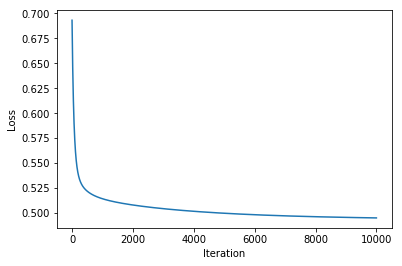

Amount predict Long 226.0
Amount predict Short 9.0
Amount Long:  182.0
Amount Short:  53.0
Amount incorrect: 50.0
Accuracy 0.7872340425531915


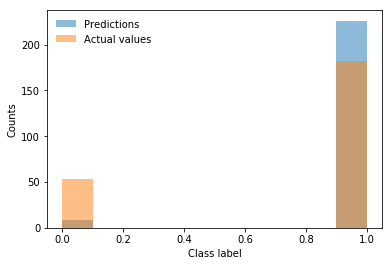

In [539]:
# Initialize weights and biases
w = np.zeros((features.shape[1],1))
b = 0

numit = 10000
loss = np.zeros(numit)
alpha = 0.01
for i in range(numit):
    w, b, loss[i] = gradient_descent(w, features, b, labels, alpha, True)


print (loss[:10])
plt.plot(loss)
plt.ylabel('Loss')
plt.xlabel('Iteration')
plt.show()

# Final prediction
yhat = sigmoid(np.dot(features,w)+b)
# Decision boundary at 0.5
yhat[yhat > 0.5] = 1
yhat[yhat < 0.5] = 0
print ("Amount predict Long", np.sum(yhat))
print ("Amount predict Short", len(yhat)-np.sum(yhat))

print ("Amount Long: ", np.sum(labels))
print ("Amount Short: ", len(labels)-np.sum(labels))

print ('Amount incorrect:', np.sum(np.abs(yhat-labels)))
print ('Accuracy', 1 - np.sum(np.abs(yhat-labels))/len(labels))

plt.hist(yhat.flatten(),label='Predictions',alpha=0.5)
plt.hist(labels.flatten(),label='Actual values',alpha=0.5)
plt.legend(frameon=False)
plt.xlabel('Class label')
plt.ylabel('Counts')
plt.show()

if len(test) > 0:
    print ("Test set:")
    # Final prediction on test set
    yhat = sigmoid(np.dot(test,w)+b)
    # Decision boundary at 0.5
    yhat[yhat > 0.5] = 1
    yhat[yhat < 0.5] = 0
    print ("Amount predict Long", np.sum(yhat))
    print ("Amount predict Short", len(yhat)-np.sum(yhat))

    print ("Amount Long: ", np.sum(testlabels))
    print ("Amount Short: ", len(testlabels)-np.sum(testlabels))

    print ('Amount incorrect:', np.sum(np.abs(yhat-testlabels)))
    print ('Accuracy', 1 - np.sum(np.abs(yhat-testlabels))/len(testlabels))

# print (np.where(np.abs(yhat-train_y_small))[0])

In [540]:
# Final prediction on whole 2D space
all_features = np.zeros((30*30,2))
count = 0
for z in np.linspace(-1,3.8,30):
    for logm in np.linspace(-2,2,30):
        all_features[count] = [z,logm]
        count +=1

# Append first two squared.
all_features = np.append(all_features,(all_features[:,0]**2)[:,np.newaxis],axis=1)  
all_features = np.append(all_features,(all_features[:,1]**2)[:,np.newaxis],axis=1)  
       
# Append first two third.
all_features = np.append(all_features,(all_features[:,0]**3)[:,np.newaxis],axis=1)  
all_features = np.append(all_features,(all_features[:,1]**3)[:,np.newaxis],axis=1)  
        
    
yhat = sigmoid(np.dot(features,w)+b)
yhatp = sigmoid(np.dot(all_features,w)+b)

ft1 = 0
ft2 = 1
# yhatp = yhatp > 0.5
plt.scatter(all_features[:,ft1],all_features[:,ft2],c=yhatp[:,0]
            ,vmin=0,vmax=1)
plt.xlabel(flabels[ft1])
plt.ylabel(flabels[ft2])
plt.colorbar()
plt.show()

yhat_predict = yhat>0.5
ft1 = 0
ft2 = 1
plt.title("Predicted")
plt.scatter(features[:,ft1],features[:,ft2],c=yhat_predict[:,0])
plt.xlabel(flabels[ft1])
plt.ylabel(flabels[ft2])
plt.colorbar()
plt.show()

ft1 = 0
ft2 = 1
plt.title("Actual")
plt.scatter(features[:,ft1],features[:,ft2],c=labels[:,0])
plt.xlabel(flabels[ft1])
plt.ylabel(flabels[ft2])
plt.colorbar()
plt.show()

ValueError: shapes (900,6) and (12,1) not aligned: 6 (dim 1) != 12 (dim 0)

In [ ]:
# Check prediction on entire dataset
data = np.loadtxt('./GRBs.txt', comments='#', usecols=(2,3,4,5,6,7,8))

# Labels are based on T90 values
T90 = data[:,1] 
labels = make_labels(T90) # shape (235,1)

# Features are all things that are not T90
features = np.copy(data[:,[0,2,3,4,5,6]]) # shape (235,6)

print ("Shape of the data", features.shape)

# Remove missing data
features, labels = check_missing_data(features, labels)


# Then standardize the data, ignoring the missing values
features = standardize(features,setmean)

# Only use first two columns
features = features[:,:2]

# Append all squared features, track missing values
missing = features == -1
sqfeatures = features**2.
sqfeatures[missing] = -1
# Standardize square features too
sqfeatures = standardize(sqfeatures, setmean)
features = np.append(features,sqfeatures,axis=1)  


# Final prediction
yhat = sigmoid(np.dot(features,w)+b)
# Decision boundary at 0.5
yhat[yhat > 0.5] = 1
yhat[yhat < 0.5] = 0
print ("Amount predict Long", np.sum(yhat))
print ("Amount predict Short", len(yhat)-np.sum(yhat))

print ("Amount Long: ", np.sum(labels))
print ("Amount Short: ", len(labels)-np.sum(labels))

print ('Amount incorrect:', np.sum(np.abs(yhat-labels)))
print ('Accuracy', 1 - np.sum(np.abs(yhat-labels))/len(labels))

plt.hist(yhat.flatten(),label='Predictions',alpha=0.5)
plt.hist(labels.flatten(),label='Actual values',alpha=0.5)
plt.legend(frameon=False)
plt.xlabel('Class label')
plt.ylabel('Counts')
plt.show()



In [ ]:
# Investigate data
# plt.scatter(features[:,0],labels[:,0])
# plt.xlabel('Redshift')
# plt.ylabel('Class')
# plt.show()

data = np.loadtxt('./GRBs.txt', comments='#', usecols=(2,3,4,5,6,7,8))

# Labels are based on T90 values
T90 = data[:,1] 
labels = make_labels(T90) # shape (235,1)

# Features are all things that are not T90
features = np.copy(data[:,[0,2,3,4,5,6]]) # shape (235,6)

print ("Shape of the data", features.shape)

# First check missing values
features, labels = check_missing_data(features, labels)


# Then standardize the data, ignoring the missing values
features = standardize(features)

for i in range(0,features.shape[1]):
    for j in range(0,i+1):
        if i != j:
            keep = np.bitwise_and(features[:,i] != 0, features[:,j] != 0)
            fti = features[:,i][keep]
            ftj = features[:,j][keep]
#             plt.scatter(features[:,i],features[:,j],c=labels[:,0])

            plt.title(f"Num points {len(fti)}")
            plt.scatter(fti,ftj,c=labels[keep,0])
            plt.xlabel(flabels[i])
            plt.ylabel(flabels[j])
            plt.colorbar()
            plt.show()


# ft1 = 0
# ft2 = 1
# plt.scatter(features[:,ft1],features[:,ft2],c=labels[:,0])
# plt.xlabel(flabels[ft1])
# plt.ylabel(flabels[ft2])
# plt.colorbar()
# plt.show()

# ft1 = 1
# ft2 = 2
# plt.scatter(features[:,ft1],features[:,ft2],c=labels[:,0])
# plt.xlabel(flabels[ft1])
# plt.ylabel(flabels[ft2])
# plt.colorbar()
# plt.show()

# ft1 = 2
# ft2 = 3
# plt.scatter(features[:,ft1],features[:,ft2],c=labels[:,0])
# plt.xlabel(flabels[ft1])
# plt.ylabel(flabels[ft2])
# plt.colorbar()
# plt.show()

# ft1 = 3
# ft2 = 4
# plt.scatter(features[:,ft1],features[:,ft2],c=labels[:,0])
# plt.xlabel(flabels[ft1])
# plt.ylabel(flabels[ft2])
# plt.colorbar()
# plt.show()

# ft1 = 4
# ft2 = 5
# plt.scatter(features[:,ft1],features[:,ft2],c=labels[:,0])
# plt.xlabel(flabels[ft1])
# plt.ylabel(flabels[ft2])
# plt.colorbar()
# plt.show()

From inspecting the 2D projected plots, no clear regions can be found where the bursts are short as opposed to long. Therefore, the logistic regression algorithm does not perform very good. This is worsened by the fact that for all features except redshift, most of the values are missing. Combining features only makes sense if both features are not missing so effectively we only have very little features to work with.